# Data Description
**ga_sessions.csv**: 1 row = 1 visit of the website \
`session_id` - ID of a site visit \
`client_id` - ID of a client \
`visit_date` - date of the visit \
`visit_time` - time of the visit \
`visit_number` - serial number of the client's visit to the site \
`utm_source` - source of customer acquisition \
`utm_medium` - means of customer acquisition \
`utm_campaign` - advertising campaign \
`utm_adcontent` - advertisement \
`utm_keyword ` - keyword in the advertisement \
`device_category` - category of the client's device \
`device_os` - operating system of the client's device \
`device_brand` - brand of the client's device \
`device_model` - model of the client's device \
`device_screen_resolution` - screen resolution of the client's device \
`device_browser` - web browser on the client's device \
`geo_country` - IP country\
`geo_city` - IP city \
\
**ga_hits.csv**: 1 row - 1 event within a visit \
`session_id` -  id of a site visit \
`hit_date` - date of the event  \
`hit_time` - time of the event \
`hit_number` - the event's serial number within a session \
`hit_type` - type of the event\
`hit_referer` - web source whence the client came from \
`hit_page_path` - page URL, where the event was registered \
`event_category` - category of what the client did on the webpage \
`event_action` - what the client did on the webpage (**target value**)\
`event_label` - tag of the client's action\
`event_value` - the value of the event's realization

# Business Understanding

**The Task**

Develop a model capable of predicting whether a user performs a specific target action (minimal ROC-AUC value - 0.65). The model should be deployed as a service that accepts all attributes, including `utm_*`, `device_*`, `geo_*`, and provides a Boolean forecast whether a user performs a target action or not.


**Analysis**

`ga_hits` contains information about online actions within a session and it is to be predicted whether a target action is going to be among them. However, since we don't have visibility into the program that generates these logs, we can only make assumptions about its logic. One possible assumption is that all entries for a new "ga_hits" row are generated at the moment a customer clicks a mouse. This would imply that all of them cannot anticipate the target and therefore cannot be used as input for a model. On the other hand, this logic should not be necesseraly the only one possible.

Let's categorize the parameters into two groups: concurrent features, which are 100% simultaneous with the target action, and the second groupe that may be generated and stored by the log-writing program before any clicks. **This second group will include features that theoretically could be part of the input information for the model.**

**Cunccurent features:**
- `event_category`
- `event_label`
- `event_value`
- `hit_time` and `hit_date` (seems to be a separation of TimeStamp)
- `hit_number`
- `hit_type`

**Features that may be stored:**
- `session_id` - this may be calculated at the beginning of a session and before any click
- `hit_referer` - this may be registered at the beginning of a session and before any click
- `hit_page_path` - this is likely to be registered at the moment of openning a webpage and before any click on it. 

In [1]:
# target values in event_action according to the task
target_values = ['sub_car_claim_click',
                 'sub_car_claim_submit_click',
                 'sub_open_dialog_click',
                 'sub_custom_question_submit_click',
                 'sub_call_number_click',
                 'sub_callback_submit_click',
                 'sub_submit_success',
                 'sub_car_request_submit_click']

In [2]:
# features to be excluded from the teaching dataset as simultaneous with the target
simultaneous_features = ['event_category',
                         'event_label',
                         'event_value',
                         'hit_time',
                         'hit_date',
                         'hit_number',
                         'hit_type']

# Imports

In [ ]:
# !pip install researchpy
# !pip install xgboost
# !pip install -U imbalanced-learn

In [4]:
import pandas as pd
import numpy as np
import re
import joblib
import json
import datetime

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable

import researchpy as rp
from urllib.parse import *
import scipy.sparse as sp

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

## Data imports

In [5]:
sessions = pd.read_csv ('data/ga_sessions.csv')
hits = pd.read_csv('data/ga_hits.csv')

C:\Users\Ivan\AppData\Local\Temp\ipykernel_7528\3900520635.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  sessions = pd.read_csv ('data/ga_sessions.csv')


In [102]:
# Data merged and yet to be cleaned
# Skipping the 'session_id' column as unique and irrelevant for ML
df_raw = pd.read_csv('data/merged.csv',
                 usecols=range(1, 28),
                 dtype = {'client_id':'str',
                          'visit_number': 'Int32',
                          'utm_source': 'str',
                          'utm_medium': 'str',
                          'utm_campaign': 'str',
                          'utm_adcontent': 'str',
                          'utm_keyword': 'str',
                          'device_category': 'str',
                          'device_os': 'str',
                          'device_brand': 'str',
                          'device_model': 'str',
                          'device_screen_resolution': 'str',
                          'device_browser': 'str',
                          'geo_country': 'str',
                          'geo_city': 'str',
                          'hit_number': 'Int32',
                          'hit_type': 'str',
                          'hit_referer': 'str',
                          'hit_page_path': 'str',
                          'event_category': 'str',
                          'event_action': 'str',
                          'event_label': 'str',
                          'event_value': 'float64'},
                parse_dates = ['visit_date',
                               'visit_time',
                               'hit_date',
                               'hit_time'])

# .sample(n=10000, random_state=34, ignore_index=True)

In [7]:
# Data cleaned, prepared for feature generation
df_feature_generation = pd.read_csv('data/clean.csv',
                        parse_dates = ['visit_date',
                                       'visit_time'])
# .sample(n=10000,random_state=34, ignore_index=True)

In [4]:
# Data with selected, refined and generated features, prepared for vectorization and standartization
df_snv = pd.read_csv('data/constuctor.csv')

# Data Merge

In [4]:
sessions_unique = set(sessions.session_id)
hits_unique = set(hits.session_id)

in_sessions_not_in_hits = len(sessions_unique - hits_unique)
in_hits_not_in_sessions = len(hits_unique - sessions_unique)
total_unique = len(hits_unique|sessions_unique)

match = len(sessions_unique & hits_unique)
mismatch = len(sessions_unique ^ hits_unique)

print (f'total_unique: {total_unique}, sessions_unique: {len(sessions_unique)}, hits_unique: {len(hits_unique)}\n\n'
       f'match: {match}, share: {match/total_unique:.2}\n'
       f'mismatch: {mismatch}, share: {mismatch/total_unique:.2}\n\n'
                     
       f'in "sessions"- not in "hits": {in_sessions_not_in_hits}, share: {in_sessions_not_in_hits/total_unique:.1}\n'
       f'in "hits" - not in "sessions": {in_hits_not_in_sessions}, share: {in_hits_not_in_sessions/total_unique:.1}\n\n'
       
       f'currently NaN traget values: {hits.event_action.isnull().sum()}')

total_unique: 1862386, sessions_unique: 1860042, hits_unique: 1734610

match: 1732266, share: 0.93
mismatch: 130120, share: 0.07

in "sessions"- not in "hits": 127776, share: 0.07
in "hits" - not in "sessions": 2344, share: 0.001

currently NaN traget values: 0


1. If adjust `sessions` to `hits`- 7% of `sessions` data will be lost.
2. If adjust  `hits` to `sessions` -  0.1% of `hits` data will be lost, incld. target values.
3. If combine `sessions` and `hits`, the mismatch will result in many incomplete entries.

**Solution**: To avoid losing information and extra uncertainty at the same time, we will perform two operations sequentially:
1. Merge the two DataFrames by outer join. 
2. In the merged file - remove the rows with empty target values ('event_action')

In [5]:
# 1. Merging two DataFrames by outer join
df_m = sessions.merge(hits, how='outer', on='session_id', copy=False)

# 2. Removing rows with empty target values ('event_action')
df_mp = df_m[df_m.event_action.notna()]

print (f'Rows with target NaN values deleted from the merged file: {len(df_m)-len(df_mp)}, share: {round((len(df_m)-len(df_mp))/len(df_m), 3)*100}%\n'
       f'Merged file before reduction: {df_m.shape}\n'
       f'Merged file after reduction:: {df_mp.shape}')

Rows with target NaN values deleted from the merged file: 127776, share: 0.8%
Merged file before reduction: (15854246, 28)
Merged file after reduction:: (15726470, 28)


In [6]:
df_mp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15726470 entries, 0 to 15854245
Data columns (total 28 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 object 
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              float64
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   utm_keyword               object 
 10  device_category           object 
 11  device_os                 object 
 12  device_brand              object 
 13  device_model              object 
 14  device_screen_resolution  object 
 15  device_browser            object 
 16  geo_country               object 
 17  geo_city                  object 
 18  hit_date                  object 
 19  hit_time                  float64
 20  hit_number            

In [7]:
df_mp.to_csv('data/merged.csv', index=False)

# Data Cleaning

## Functions 

In [5]:
# missing values visualization
def missing_values(x):
    return (x.isna().sum() / len(x)).sort_values(ascending=False)

# deleting features with over 30% NaNs or with only 1 value
def drop_noninfo_features (data):
    list_to_drop = []
    missings = missing_values(data)
    for feat in missings.index:
        if missings[feat] > 0.3 or data[feat].nunique() <= 1:
            list_to_drop.append(feat)
    print (f'dropped features:{len(list_to_drop)} \n {list_to_drop}')
    return data.drop(columns = list_to_drop, inplace=True)

# duplicates elimination per rows and per columns
def drop_duplicates (data):
    original_length = len(data)
    data.drop_duplicates(inplace=True)
    print (f'duplicated rows removed: {original_length - len(data)}')
    
    sample = data.sample (n=1000, random_state=34, ignore_index=True)
    duplicated_columns = sample.columns[sample.T.duplicated()].tolist()
    data.drop(columns=duplicated_columns, inplace=True)
    print (f'duplicated columns removed: {duplicated_columns}')

# separation of features per dtypes
def types_sep (data):
    numerical = data.select_dtypes(include=['int64','Int32','float64']).columns
    categorical = data.select_dtypes(include=['object']).columns
    datetime = data.select_dtypes(include=['datetime64']).columns
    return {'numerical':numerical, 'categorical':categorical, 'datetime':datetime}

# filling in numerical and categorical missing data
def fill_in_gaps(data):
    for feat in types_sep(data)['numerical']:
        data.loc[:, feat] = data[feat].fillna(data[feat].median())
    for feat in types_sep(data)['categorical']:
        data.loc[:, feat] = data[feat].fillna(data[feat].mode()[0])

# filling in datetime missing data
def time_gaps (visits, hits):
    try: visits.fillna(pd.to_datetime(hits), inplace=True) 
    except: visits.fillna(visits.mode()[0], inplace=True)
    print (f'{visits.name} missing values: {visits.isna().sum()}\n'
           f'{visits.name} dtype: {visits.dtype}')

# outliers control
def boundaries (data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    return q25 - 1.5 * iqr, q75 + 1.5 * iqr

# outliers visualization
def outliers_n_boxplots (data):
    for feat in types_sep(data)['numerical']:
        lower_bound, upper_bound = boundaries(data[feat])[0], boundaries(data[feat])[1]
        outliers = ((data[feat] < lower_bound) | (data[feat] > upper_bound)).sum()
        plt.figure (figsize=(5, 5))
        plt.boxplot(data[feat])
        plt.ylabel(data[feat].name)
        plt.title(f'outliers in {data[feat].name}')
        print (f'outliers in {data[feat].name}: {outliers}\n'
               f'share: {outliers / len(data):.2}')

# replacing the outliers in numerical data with the respective boundary values
def replace_outliers (data):
    for feat in types_sep(data)['numerical']:
        lower_bound, upper_bound = boundaries(data[feat])[0], boundaries(data[feat])[1]
        outliers = ((data[feat] < lower_bound) | (data[feat] > upper_bound)).sum()
        print (f'outliers in {data[feat].name} replaced: {outliers}\n'
               f'share: {outliers / len(data):.2}')
        data.loc[:,feat].mask (data[feat] < lower_bound, other=int(lower_bound), inplace=True)
        data.loc[:,feat].mask (data[feat] > upper_bound, other=int(upper_bound), inplace=True)
        
# data cleanliness check
def data_cleanliness_check (before, now):
    duplicates = now.duplicated()
    missing_values = [now[f].isna().sum() for f in now.columns.tolist()]
    outliers = [((now[f]<boundaries(now[f])[0])|(now[f]>boundaries(now[f])[1])).sum() \
                for f in types_sep(now)['numerical']]      
    rows_diff = len(before)-len(now)
    column_diff = before.shape[1] - now.shape[1]
    
    print (f'duplicates: {duplicates.sum()}\n'
           f'missing values: {sum(missing_values)}\n'
           f'outliers: {sum(outliers)}\n'
           va'
           f'columns deleted: {column_diff}, share: {column_diff/before.shape[1]:.2}')

## Data Cleaning Process

In [ ]:
df_cp = df_raw.copy()

In [7]:
# deleting features with over 30% NaNs or with only 1 value
drop_noninfo_features(df_cp)

dropped features:7 
 ['event_value', 'device_model', 'utm_keyword', 'device_os', 'hit_time', 'hit_referer', 'hit_type']


In [8]:
# filling in numerical and categorical missing data
fill_in_gaps(df_cp)

In [9]:
# filling in missing visit_date data
time_gaps(df_cp.visit_date, df_cl.hit_date)

visit_date missing values: 0
visit_date dtype: datetime64[ns]


In [10]:
# filling in missing visit_time data
time_gaps(df_cp.visit_time, df_cl.hit_time)

visit_time missing values: 0
visit_time dtype: datetime64[ns]


outliers in visit_number: 1418068
share: 0.09
outliers in hit_number: 1061598
share: 0.068


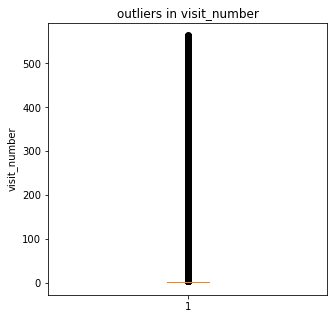

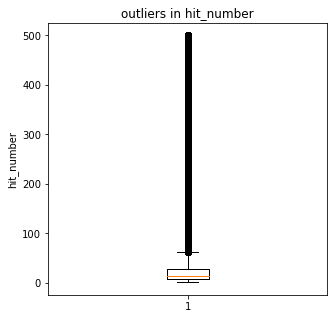

In [11]:
outliers_n_boxplots (df_cp)

In [12]:
replace_outliers(df_cp)

outliers in visit_number replaced: 1418068
share: 0.09
outliers in hit_number replaced: 1061598
share: 0.068


In [13]:
data_cleanliness_check (df_cl, df_cp)

duplicates: 831562
missing values: 0
outliers: 0
rows deleted: 0, share: 0.0
columns deleted: 7, share: 0.26


In [14]:
drop_duplicates(df_cp)

duplicated rows removed: 831562
duplicated columns removed: ['hit_date']


In [15]:
# some new outliers emerged due to the removal of duplicates, which caused a slight destribution change.
data_cleanliness_check (df_cl, df_cp)

duplicates: 0
missing values: 0
outliers: 653103
rows deleted: 831562, share: 0.053
columns deleted: 8, share: 0.3


In [16]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14894908 entries, 0 to 15726465
Data columns (total 19 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   client_id                 object        
 1   visit_date                datetime64[ns]
 2   visit_time                datetime64[ns]
 3   visit_number              Int32         
 4   utm_source                object        
 5   utm_medium                object        
 6   utm_campaign              object        
 7   utm_adcontent             object        
 8   device_category           object        
 9   device_brand              object        
 10  device_screen_resolution  object        
 11  device_browser            object        
 12  geo_country               object        
 13  geo_city                  object        
 14  hit_number                Int32         
 15  hit_page_path             object        
 16  event_category            object        
 17  event_

In [17]:
df_cp.to_csv('data/clean.csv', index=False)

# Feature Engineering

## Functions

In [6]:
# data description per feature
def feature_analysis (data):
    for feat in data.columns.tolist():
        print(f'\033[1m{feat}\033[0m\n'
              f'dtype: \033[1m{data[feat].dtype}\033[0m\n'
              f'Missing values: \033[1m{data[feat].isna().sum()}\033[0m\n'
              f'Missing values share: \033[1m{data[feat].isna().sum()/len(data):.2}\033[0m\n'
              f'unique values number: \033[1m{data[feat].nunique()}\033[0m\n'
              f'first \033[1m 3 most frequent\033[0m values: \n{data[feat].value_counts(normalize=True).head(3)}\n')

# turning target into a Boolean variable
def target_value (data, feat):
    data[feat] = data[feat].apply(lambda x: 1 if x in target_values else 0)
    print (f'unique target values: \033[1m{data[feat].unique()}\033[0m \n'
           f'values frequency: \033[1m \n{data[feat].value_counts(normalize=True)}\033[0m \n')

# Boolean for organic trafic
def organic_traffic (data, utm_medium):
    organic_values = ['organic',
                      'referral',
                      '(none)']

    data['organic_traffic'] = data[utm_medium].apply(lambda x: 1 if x in organic_values else 0)
    print (f'organic_traffic values frequency: \033[1m \n{data["organic_traffic"].value_counts(normalize=True)}\033[1m \n')

# Boolean for social media advertising
def SMM (data, utm_source):
    SMM_values = ['QxAxdyPLuQMEcrdZWdWb',
                  'MvfHsxITijuriZxsqZqt',
                  'ISrKoXQCxqqYvAZICvjs',
                  'IZEXUFLARCUMynmHNBGo',
                  'PlbkrSYoHuZBWfYjYnfw',
                  'gVRrcxiDQubJiljoTbGm']

    data['SMM'] = data[utm_source].apply(lambda x: 1 if x in SMM_values else 0)
    print (f'SMM values frequency: \033[1m \n{data["SMM"].value_counts(normalize=True)}\033[0m \n')

# Car models and brands manually extracted from URL. 
# To be compared with the respective automated URLs' parsing results.
def car_brand(data, hit_page_path):
    data['car_brand'] = data[hit_page_path].apply(lambda x: x.split('=')[1].split('&')[0] if 'brand' in x else 0).astype(str)
    data['car_brand'].fillna(0, inplace=True)
    
    unique_brand = data['car_brand'].nunique()
    frequency_brand = data['car_brand'].value_counts(normalize=True).head(3)
    
    print(f'feature "car_brand" generated with: \033[1m{unique_brand}\033[0m unique values')
    print(f'"car_brand" values frequency (first 3): \033[1m\n{frequency_brand}\033[1m\n')

def car_model(data, hit_page_path):
    data['car_model'] = data[hit_page_path].apply(lambda x: x.split('model')[1].split('=')[1].split('&')[0] if 'model' in x else 0).astype(str)
    data['car_model'].fillna(0, inplace=True)
    
    unique_model = data['car_model'].nunique()
    frequency_model = data['car_model'].value_counts(normalize=True).head(3)
    
    print(f'feature "car_model" generated with: \033[1m{unique_model}\033[1m unique values')
    print(f'"car_model" values frequency (first 3): \033[1m\n{frequency_model}\033[1m\n')

# hour of the visit
def hour (data, visit_time):
    data['hour'] = data[visit_time].dt.hour.astype(int)
    print (f'"hour" values frequency (first 3 of 24): \033[1m \n{data["hour"].value_counts(normalize=True).head(3)}\033[0m \n')

# day of the week
def day_of_the_week (data, visit_date):
    data['day_of_the_week'] = data[visit_date].apply(lambda x: x.isoweekday()).astype(int)
    print (f'"day_of_the_week" values frequency (first 3): \033[1m \n{data["day_of_the_week"].value_counts(normalize=True).head(3)}\033[0m \n')
    
# month
def month (data, visit_date):
    data['month'] = data[visit_date].apply(lambda x: x.month).astype(int)
    print (f'"month" values frequency (3 most frequent): \033[1m \n{data["month"].value_counts(normalize=True).head(3)}\033[0m \n')

# new features generated from parsing URLs 
def parse_url(data, feat):
    parsed_queries_keys = set()
    for url in data[feat]:
        parsed_queries = parse_qs(urlparse(url).query)
        parsed_queries_keys.update(parsed_queries.keys())

    for elem in parsed_queries_keys:
        data[elem] = [str(parse_qs(urlparse(url).query).get(elem, [0])[0]) for url in data[feat]]
        print(f'feature {elem} generated with \033[1m{data[elem].nunique()}\033[0m unique values')
        print(f'{elem} values frequency (first 3): \033[1m \n{data[elem].value_counts(normalize=True).head(3)}\033[0m \n\n')

    data['path'] = [str(urlparse(url).path) for url in data[feat]]
    print(f'feature "path" generated with \033[1m{data["path"].nunique()}\033[0m unique values')
    print(f'"path" values frequency (first 3): \033[1m \n{data["path"].value_counts(normalize=True).head(3)}\033[0m \n\n')

    data['url_len'] = [len(url) for url in data[feat]]
    print(f'feature "url_len" generated with \033[1m{data["url_len"].nunique()}\033[0m unique values')
    print(f'"url_len" values frequency (first 3): \033[1m \n{data["url_len"].value_counts(normalize=True).head(3)}\033[0m \n\n')

    data['special_char'] = [len(re.findall(r'[^A-Za-z0-9]', url)) for url in data[feat]]
    print(f'feature "special_char" generated with \033[1m{data["special_char"].nunique()}\033[0m unique values')
    print(f'"special_char" values frequency (first 3): \033[1m \n{data["special_char"].value_counts(normalize=True).head(3)}\033[0m \n\n')

    data['url_hierarchy'] = [urlparse(url).path.count('/') for url in data[feat]]
    print(f'feature "url_hierarchy" generated with \033[1m{data["url_hierarchy"].nunique()}\033[0m unique values')
    print(f'"url_hierarchy" values frequency (first 3): \033[1m \n{data["url_hierarchy"].value_counts(normalize=True).head(3)}\033[0m \n\n')

# different visit parameters aggregated per client
def per_client_features (data):
    n_params = ['event_category',
                'event_label',
                'hit_page_path',
                'device_screen_resolution',
                'utm_adcontent',
                'utm_campaign',
                'utm_source',
                'utm_medium']

    for feat in n_params:
        new_feat = f'n_{feat}'
        data[new_feat] = data.groupby('client_id')[feat].transform('nunique').astype(int)
        print (f'feature {new_feat} generated with {data[new_feat].nunique()} unique values')
        print (f'{new_feat} values frequency (first 3): \033[1m \n{data[new_feat].value_counts(normalize=True).head(3)}\033[0m \n\n')

# Correlation table for categorical features, based on Cramer's V coefficient.
def categoricals_corr (data, target):
    
    cat_corr = pd.DataFrame (columns = ['feature',
                                        'correlation_with_target',
                                        'level_of_correlation'])
    
    for feat in types_sep(data)['categorical']:
        _, results = rp.crosstab(data[target], data[feat], test='chi-square')
        cramers_v = results.loc[2, 'results']

        level_of_correlation = 'Weak' if cramers_v < 0.1 \
                                else 'Moderate' if cramers_v < 0.3\
                                else 'Strong'

        new_line = {'feature': feat,
                    'correlation_with_target': cramers_v,
                    'level_of_correlation': level_of_correlation}

        cat_corr.loc[len(cat_corr)] = new_line
    
    return cat_corr.sort_values('correlation_with_target', ascending=False)


# Correlation table for numerical features, based on Pearson's r.
def numericals_corr (data, target):
    num_corr = pd.DataFrame (columns = ['feature',
                                        'correlation_with_target',
                                        'level_of_correlation'])
    for feat in types_sep(data)['numerical']:
        corr_value = data[feat].corr(data["event_action"])
        
        level_of_correlation =  'Weak' if abs(corr_value) < 0.3 \
                                else 'Moderate' if abs(corr_value) < 0.7 \
                                else 'Strong'
        new_line = {'feature': feat,
                    'correlation_with_target': corr_value,
                    'level_of_correlation': level_of_correlation}

        num_corr.loc[len(num_corr)] = new_line
    
    return num_corr[(num_corr.feature != 'event_action')].\
           sort_values('correlation_with_target', ascending=False)

# Categorical features correlation matrix (equivalent to .corr() for numerical features)
def cramers_v_matrix (data):
    categoricals = types_sep(data)['categorical']
    correlation_matrix = pd.DataFrame(index=categoricals, 
                                      columns=categoricals)  
    for col1 in categoricals:
        for col2 in categoricals:
            _, results = rp.crosstab(data[col1], data[col2], test='chi-square')
            cramers_v = results.loc[2, 'results']
            correlation_matrix.loc[col1, col2] = cramers_v
    return correlation_matrix

# Extracts pairs of highly correlated features from cramers_v_matrix
def get_high_correlation_pairs(correlation_matrix, threshold=0.9):
    high_correlation_pairs = {}
    for col1 in correlation_matrix.columns:
        for col2 in correlation_matrix.columns:
            if col1 != col2 and correlation_matrix.loc[col1, col2] >= threshold:
                if (col1, col2) not in high_correlation_pairs and (col2, col1) not in high_correlation_pairs:
                    high_correlation_pairs[(col1, col2)] = correlation_matrix.loc[col1, col2]
    return high_correlation_pairs

# Visualization of features' correlation with the target
def corr_hist(data):
    data = data.sort_values('correlation_with_target', ascending=True)
    color_mapping = {'Weak': 'Salmon',
                     'Moderate': 'Beige',
                     'Strong': 'Teal'}
    plt.figure(figsize=(10, 15))
    plt.barh(data.feature, abs(data.correlation_with_target), color=data['level_of_correlation'].map(color_mapping))
    plt.xlabel('Correlation with Target')
    plt.ylabel('Feature')
    plt.title('Correlation of Features with Target')
    legend_handles = [Patch(facecolor=color, label=level) for level, color in color_mapping.items()]
    plt.legend(handles=legend_handles,loc='lower right')
    plt.show()
    
# This function drops weakly correlated features     
def drop_weak_corr_feat (data, corr_df, significance_level):
    list_to_drop = corr_df[(corr_df.correlation_with_target < significance_level)].feature.tolist() 
    data.drop(columns = list_to_drop, inplace=True)
    print (f'feaures dropped: \n{list_to_drop}')
    
# Makes a list of categorical and numerical features, drops irrelevant for ML dtypes as datetime.    
def relevant_features (data):
    categoricals = set(types_sep(data)['categorical'])
    numericals = set(types_sep(data)['numerical'])
    relevant_features_set = categoricals | numericals
    print (f'number of features: \033[1m{len(relevant_features_set)}\033[0m')
    return list(relevant_features_set)

## Sample Study
A 10K items sample is enough to extrapolate its characteristics on the population.
A 95% confidence interval for the numericals and frequencies of the categoricals in this sample would be: 

`sample feature mean +/- (sample feature standard deviation * 0,02)`

The magnitude of this adjustment is negligible for judgments about the nature of the population.

### Sample Feature Engineering

In [33]:
sample = df_feature_generation.sample(n=10000, random_state=34, ignore_index=True)

Although maintaining the target feature as a set of original categories results in higher correlations with the categorical features, it is more logical to convert it into a Boolean variable at an early stage. In the given task of forecasting a binary outcome, studying the relationship between each possible value of the target and other features becomes redundant. Therefore, we will transform the target into a Boolean variable first and then assess its correlation with the features.

In [39]:
# turning target into a Boolean variable
target_value (sample, 'event_action')

unique target values: [0 1] 
values frequency:  
0    0.9932
1    0.0068
Name: event_action, dtype: float64 



In [40]:
# Boolean for organic traffic
organic_traffic (sample, 'utm_medium')

organic_traffic values frequency:  
0    0.6315
1    0.3685
Name: organic_traffic, dtype: float64 



In [41]:
# Boolean for social media advertising
SMM (sample, 'utm_source')

SMM values frequency:  
0    0.9222
1    0.0778
Name: SMM, dtype: float64 



In [42]:
# hour of the session
hour (sample, 'visit_time')

"hour" values frequency (first 3 of 24):  
14    0.0638
16    0.0612
13    0.0610
Name: hour, dtype: float64 



In [43]:
# day of the week when the session occured
day_of_the_week (sample, 'visit_date')

"day_of_the_week" values frequency (first 3):  
1    0.1798
2    0.1726
4    0.1480
Name: day_of_the_week, dtype: float64 



In [44]:
# month of the session
month (sample, 'visit_date')

"month" values frequency (3 most frequent):  
12    0.2178
10    0.1490
11    0.1484
Name: month, dtype: float64 



In [45]:
# Car models and brands manually extracted from URL. 
# To be compared with the respective automated URLs' parsing results.
car_model (sample, 'hit_page_path')

feature "car_model" generated with: 6 unique values
"car_model" values frequency (first 3): 
0       0.9995
2449    0.0001
3015    0.0001
Name: car_model, dtype: float64



In [46]:
car_brand (sample, 'hit_page_path')

feature "car_brand" generated with: 12 unique values
"car_brand" values frequency (first 3): 
0      0.9987
192    0.0002
232    0.0002
Name: car_brand, dtype: float64



In [47]:
# new features generated from parsing URLs 
parse_url (sample, 'hit_page_path')

feature c generated with 2 unique values
c values frequency (first 3):  
0           0.9917
sberauto    0.0083
Name: c, dtype: float64 


feature yzclid generated with 45 unique values
yzclid values frequency (first 3):  
0                      0.9955
5366608814537879647    0.0002
2331647426734280830    0.0001
Name: yzclid, dtype: float64 


feature wbraid generated with 7 unique values
wbraid values frequency (first 3):  
0                                                                                 0.9994
cjgkcajw6zoibhbbeigaspgas4-xijhcjozz_r0kgmobix8gp7chzww6uqx0ron-xfs6tunoggkmzq    0.0001
cjgkcajwos-hbhbueigazjthuatwxho0zeniq8ukrkmcrz_ay3jp8a4eysvk8hotgvtjgf20ggi5dg    0.0001
Name: wbraid, dtype: float64 


feature shortlink generated with 2 unique values
shortlink values frequency (first 3):  
0                 0.9917
opensearchcars    0.0083
Name: shortlink, dtype: float64 


feature labels generated with 2 unique values
labels values frequency (first 3):  
0                

In [48]:
# cumulative data as per a client
per_client_features (sample)

feature n_event_category generated with 4 unique values
n_event_category values frequency (first 3):  
1     0.9784
2     0.0178
11    0.0024
Name: n_event_category, dtype: float64 


feature n_event_label generated with 3 unique values
n_event_label values frequency (first 3):  
1     0.9810
2     0.0166
10    0.0024
Name: n_event_label, dtype: float64 


feature n_hit_page_path generated with 5 unique values
n_hit_page_path values frequency (first 3):  
1     0.9767
2     0.0186
21    0.0024
Name: n_hit_page_path, dtype: float64 


feature n_device_screen_resolution generated with 2 unique values
n_device_screen_resolution values frequency (first 3):  
1    0.9967
2    0.0033
Name: n_device_screen_resolution, dtype: float64 


feature n_utm_adcontent generated with 2 unique values
n_utm_adcontent values frequency (first 3):  
1    0.9992
2    0.0008
Name: n_utm_adcontent, dtype: float64 


feature n_utm_campaign generated with 3 unique values
n_utm_campaign values frequency (first 3)

In [49]:
# with new features
sample.columns

Index(['client_id', 'visit_date', 'visit_time', 'visit_number', 'utm_source',
       'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category',
       'device_brand', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'hit_number', 'hit_page_path',
       'event_category', 'event_action', 'event_label', 'organic_traffic',
       'SMM', 'hour', 'day_of_the_week', 'month', 'car_model', 'car_brand',
       'c', 'yzclid', 'wbraid', 'shortlink', 'labels', 'rental_page',
       'encdata', 'af_android_url', 'utm_medium_initial_initial', 'colors',
       'orderid', 'required', 'page', 'pid', 'transmissions', 'pricefrom',
       'lang', 'gtm_debug', 'utm_campaign_initial',
       'utm_source_initial_initial', 'rental_car', 'utm_medium_initial',
       'model', 'utm_content_initial', 'af_ios_url', 'steeringwheels',
       'enginetypes', 'isnew', 'referrer', 'priceto', 'utm_term_initial',
       'af_dp', 'rent_price_from', 'utm_source_initial_initial_initial',


**Support of business understanding**

At this stage, it becomes apparent that the `utm_*` parameters in the `ga_session` dataset are likely derived from the `hit_page_path` parameter in `ga_hits`. This observation strengthens the assumption that the `hit_page_path` feature precedes the other data in the `ga_hits` entries and has the potential to be used as a predictor.

### Sample Cleaning

In [50]:
sample_cleaning = sample.copy()

In [51]:
missing_values(sample_cleaning)

client_id               0.0
datefrom                0.0
dateto                  0.0
fbclid                  0.0
utm_referrer_initial    0.0
                       ... 
wbraid                  0.0
yzclid                  0.0
c                       0.0
car_brand               0.0
n_utm_medium            0.0
Length: 91, dtype: float64

In [52]:
drop_noninfo_features (sample_cleaning)

dropped features:0 
 []


In [53]:
fill_in_gaps(sample_cleaning)

In [54]:
drop_duplicates(sample_cleaning)

duplicated rows removed: 0
duplicated columns removed: ['colors', 'pricefrom', 'gtm_debug', 'model', 'af_ios_url', 'steeringwheels', 'enginetypes', 'utm_source_initial_initial_initial', 'powerfrom', 'utm_medium_initial_initial_initial', 'bodytypes', 'yhid', 'mileagefrom', 'baobab_event_id', 'frommain', 'generation', 'n_utm_campaign']


In [55]:
# Generated outliers are not mistakes and shouldn't be dropped.
data_cleanliness_check (sample, sample_cleaning)

duplicates: 0
missing values: 0
outliers: 5617
rows deleted: 0, share: 0.0
columns deleted: 17, share: 0.19


In [56]:
# features after cleaning
sample_cleaning.columns

Index(['client_id', 'visit_date', 'visit_time', 'visit_number', 'utm_source',
       'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category',
       'device_brand', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city', 'hit_number', 'hit_page_path',
       'event_category', 'event_action', 'event_label', 'organic_traffic',
       'SMM', 'hour', 'day_of_the_week', 'month', 'car_model', 'car_brand',
       'c', 'yzclid', 'wbraid', 'shortlink', 'labels', 'rental_page',
       'encdata', 'af_android_url', 'utm_medium_initial_initial', 'orderid',
       'required', 'page', 'pid', 'transmissions', 'lang',
       'utm_campaign_initial', 'utm_source_initial_initial', 'rental_car',
       'utm_medium_initial', 'utm_content_initial', 'isnew', 'referrer',
       'priceto', 'utm_term_initial', 'af_dp', 'rent_price_from',
       'utm_source_initial', 'external_browser_redirect', 'yclid',
       'utm_referrer_initial', 'fbclid', 'dateto', 'datefrom', 'rent_price_to

### Sample Features Study

In [57]:
# cumulative analitical data per each feature
feature_analysis (sample_cleaning)

client_id
dtype: float64
Missing values: 0
Missing values share: 0.0
unique values number: 9803
first  3 most frequent values: 
1.750498e+09    0.0024
1.971753e+09    0.0004
7.368596e+08    0.0004
Name: client_id, dtype: float64

visit_date
dtype: datetime64[ns]
Missing values: 0
Missing values share: 0.0
unique values number: 226
first  3 most frequent values: 
2021-05-24    0.0376
2021-12-21    0.0185
2021-05-25    0.0154
Name: visit_date, dtype: float64

visit_time
dtype: datetime64[ns]
Missing values: 0
Missing values share: 0.0
unique values number: 3961
first  3 most frequent values: 
2023-05-30 13:00:00    0.0373
2023-05-30 14:00:00    0.0362
2023-05-30 12:00:00    0.0351
Name: visit_time, dtype: float64

visit_number
dtype: int64
Missing values: 0
Missing values share: 0.0
unique values number: 3
first  3 most frequent values: 
1    0.7487
2    0.1295
3    0.1218
Name: visit_number, dtype: float64

utm_source
dtype: object
Missing values: 0
Missing values share: 0.0
unique valu

### Correlations study

In [58]:
sample_corr = sample_cleaning.copy()

#### Categoricals

In [59]:
# Correlation table for categorical features, based on Cramer's V coefficient
cat_corr = categoricals_corr (sample_corr, 'event_action')
cat_corr

,feature,correlation_with_target,level_of_correlation
12,event_label,0.8823,Strong
11,event_category,0.5497,Strong
10,hit_page_path,0.5451,Strong
34,utm_content_initial,0.2863,Moderate
52,path,0.2703,Moderate
6,device_screen_resolution,0.2290,Moderate
45,fbclid,0.2096,Moderate
38,utm_term_initial,0.1750,Moderate
30,utm_campaign_initial,0.1372,Moderate
2,utm_campaign,0.1347,Moderate


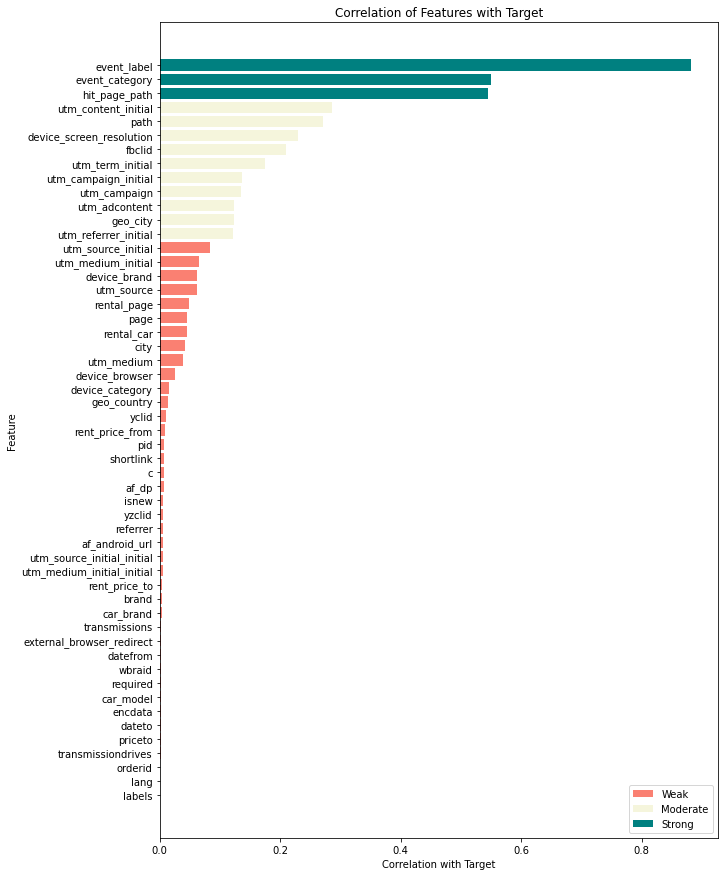

In [60]:
# Visualisation of the above table for the categoricals
corr_hist (cat_corr)

Due to the fact that our sample contains 10,000 elements - which is significantly higher than 30 - there is no need to consider degrees of freedom for the Student's t-distribution. On the contrary, there is every reason to believe that the distribution is normal and identical to the distribution of the population. Therefore, the significance level is set without adjusting for the standard error of the sample's mean.

In [61]:
# for the Cramer's V coefficient the 'weak correlation' threshold is traditionally set at 0.1  
drop_weak_corr_feat (sample_corr, cat_corr, 0.1)

feaures dropped: 
['utm_source_initial', 'utm_medium_initial', 'device_brand', 'utm_source', 'rental_page', 'page', 'rental_car', 'city', 'utm_medium', 'device_browser', 'device_category', 'geo_country', 'yclid', 'rent_price_from', 'pid', 'shortlink', 'c', 'af_dp', 'isnew', 'yzclid', 'referrer', 'af_android_url', 'utm_source_initial_initial', 'utm_medium_initial_initial', 'rent_price_to', 'car_brand', 'brand', 'transmissions', 'external_browser_redirect', 'datefrom', 'wbraid', 'required', 'car_model', 'encdata', 'dateto', 'priceto', 'transmissiondrives', 'orderid', 'lang', 'labels']


#### Numericals

In [62]:
# Correlation table for numerical features, based on Pearson's r.
num_corr = numericals_corr (sample_corr, 'event_action')
num_corr

,feature,correlation_with_target,level_of_correlation
13,n_event_label,0.070184,Weak
12,n_event_category,0.068940,Weak
14,n_hit_page_path,0.067505,Weak
15,n_device_screen_resolution,0.058890,Weak
2,hit_number,0.050141,Weak
11,url_hierarchy,0.032544,Weak
18,n_utm_medium,0.029475,Weak
17,n_utm_source,0.028132,Weak
1,visit_number,0.024000,Weak
5,SMM,0.003224,Weak


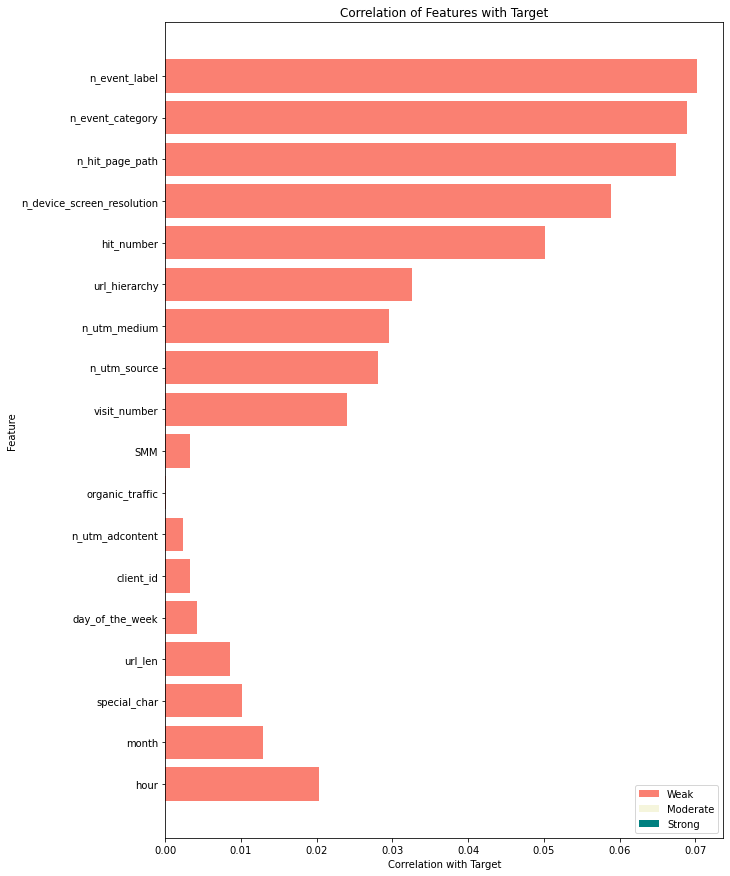

In [63]:
# Visualisation of the above table for the numericals
corr_hist (num_corr)

In [64]:
# for the  Pearson's r coefficient the 'weak correlation' threshold is traditionally set at 0.3 
# Basically that mean we need to drop all the numerical features. Thy shall be done. 
# The irrelevant for ML 'client_id' is filtered on this stage as well.
drop_weak_corr_feat (sample_corr, num_corr, 0.3)

feaures dropped: 
['n_event_label', 'n_event_category', 'n_hit_page_path', 'n_device_screen_resolution', 'hit_number', 'url_hierarchy', 'n_utm_medium', 'n_utm_source', 'visit_number', 'SMM', 'organic_traffic', 'n_utm_adcontent', 'client_id', 'day_of_the_week', 'url_len', 'special_char', 'month', 'hour']


#### Resulting features

In [65]:
# The remaining features after dropping the weakly correlated ones and datetime
relevant_features_ = relevant_features (sample_corr)
relevant_features_

number of features: 14


['path',
 'fbclid',
 'utm_campaign',
 'event_action',
 'geo_city',
 'utm_term_initial',
 'hit_page_path',
 'device_screen_resolution',
 'event_label',
 'event_category',
 'utm_campaign_initial',
 'utm_adcontent',
 'utm_referrer_initial',
 'utm_content_initial']

#### Multicollinearity

The following table represents a correlation matrix of the remaining categorical features, using Cramer's V coefficient. In the case of categorical features, there is no straightforward solution like the Variance Inflation Factor or the .corr() method used for numerical features. Therefore, a custom script was developed specifically for this matrix.

Key takeaways from the matrix are:
- All new features that surpass the significance threshold are derived from the original feature 'hit_page_path', resulting in a correlation of 1:0 with each of them.
- The new features exhibit varying correlation values with both the target variable and each other. 
- This suggests that **removing 'hit_page_path'** from the dataset would effectively address the issue of multicollinearity.

In [59]:
matrix_feed = sample_corr[relevant_features_]

In [60]:
cat_correlation_matrix = cramers_v_matrix (matrix_feed)

In [61]:
cat_correlation_matrix

,utm_content_initial,event_label,path,utm_referrer_initial,fbclid,device_screen_resolution,hit_page_path,utm_adcontent,geo_city,utm_campaign_initial,event_category,utm_term_initial,utm_campaign
utm_content_initial,1.0,0.2286,0.3128,0.2169,0.0054,0.312,1.0,0.5518,0.26,0.7569,0.2774,0.763,0.391
event_label,0.2286,1.0,0.2039,0.2145,0.0844,0.2114,0.4211,0.1964,0.2129,0.1926,0.6041,0.206,0.1799
path,0.3128,0.2039,1.0,0.1915,0.1091,0.1609,1.0,0.2143,0.1894,0.155,0.3287,0.1555,0.2071
utm_referrer_initial,0.2169,0.2145,0.1915,1.0,0.0013,0.1173,1.0,0.0939,0.2248,0.1506,0.031,0.2169,0.0946
fbclid,0.0054,0.0844,0.1091,0.0013,1.0,0.136,1.0,0.0952,0.2119,0.0086,0.122,0.0027,0.3438
device_screen_resolution,0.312,0.2114,0.1609,0.1173,0.136,1.0,0.5098,0.2776,0.1852,0.165,0.1664,0.1813,0.192
hit_page_path,1.0,0.4211,1.0,1.0,1.0,0.5098,1.0,0.649,0.4444,1.0,0.5652,1.0,0.7228
utm_adcontent,0.5518,0.1964,0.2143,0.0939,0.0952,0.2776,0.649,1.0,0.1739,0.3346,0.1498,0.3278,0.5047
geo_city,0.26,0.2129,0.1894,0.2248,0.2119,0.1852,0.4444,0.1739,1.0,0.1767,0.1891,0.154,0.2289
utm_campaign_initial,0.7569,0.1926,0.155,0.1506,0.0086,0.165,1.0,0.3346,0.1767,1.0,0.1637,0.3472,0.5391


In [62]:
get_high_correlation_pairs (cat_correlation_matrix)

{('utm_content_initial', 'hit_page_path'): 1.0,
 ('path', 'hit_page_path'): 1.0,
 ('utm_referrer_initial', 'hit_page_path'): 1.0,
 ('fbclid', 'hit_page_path'): 1.0,
 ('hit_page_path', 'utm_campaign_initial'): 1.0,
 ('hit_page_path', 'utm_term_initial'): 1.0}

In [63]:
# features to keep in the original dataframe
# this is were we drop the simulteneous ones
features_to_keep = list(set(df_feature_generation.columns) & set(relevant_features_) - set(simultaneous_features))
features_to_keep

['event_action',
 'device_screen_resolution',
 'utm_adcontent',
 'hit_page_path',
 'geo_city',
 'utm_campaign']

In [64]:
# features to generate and add to the original dataframe
features_to_generate = list(set(relevant_features_) - set(df_feature_generation.columns))
features_to_generate

['utm_content_initial',
 'path',
 'utm_referrer_initial',
 'fbclid',
 'utm_campaign_initial',
 'utm_term_initial']

## Dataset processing

### Funtions

In [7]:
def feature_constractor (data):
    data = data[features_to_keep].copy() # sorting out only the above relevant features
    target_value (data,'event_action') # target feature to Boolean    
    for elem in features_to_generate: # one algorithm for all generated features
        data[elem] = [str(parse_qs(urlparse(url).query).get(elem, [0])[0]) for url in data['hit_page_path']]
        if elem == 'path': # except for this one. It has its own algorithm
            data['path'] = [str(urlparse(url).path) for url in data['hit_page_path']]         
    data.drop('hit_page_path',axis=1, inplace=True) # dropping it to tackle the multicollinearity
    return data

### Processing

In [88]:
df_constractor = feature_constractor (df_feature_generation)

unique target values: [0 1] 
values frequency:  
0    0.993155
1    0.006845
Name: event_action, dtype: float64 



In [89]:
df_constractor.shape

(14894908, 11)

In [90]:
data_cleanliness_check (df_feature_generation, df_constractor)

duplicates: 14025319
missing values: 0
outliers: 101960
rows deleted: 0, share: 0.0
columns deleted: 8, share: 0.42


In [91]:
drop_duplicates(df_constractor)

duplicated rows removed: 14025319
duplicated columns removed: []


In [92]:
df_constractor.shape

(869589, 11)

In [93]:
feature_analysis (df_constractor)

event_action
dtype: int64
Missing values: 0
Missing values share: 0.0
unique values number: 2
first  3 most frequent values: 
0    0.96196
1    0.03804
Name: event_action, dtype: float64

device_screen_resolution
dtype: object
Missing values: 0
Missing values share: 0.0
unique values number: 4947
first  3 most frequent values: 
414x896      0.072911
1920x1080    0.068507
375x812      0.055520
Name: device_screen_resolution, dtype: float64

utm_adcontent
dtype: object
Missing values: 0
Missing values share: 0.0
unique values number: 280
first  3 most frequent values: 
JNHcPlZPxEMWDnRiyoBf    0.794864
vCIpmpaGBnIQhyYNkXqp    0.070442
xhoenQgDQsgfEPYNPwKO    0.024336
Name: utm_adcontent, dtype: float64

geo_city
dtype: object
Missing values: 0
Missing values share: 0.0
unique values number: 2389
first  3 most frequent values: 
Moscow              0.292520
Saint Petersburg    0.128243
(not set)           0.038366
Name: geo_city, dtype: float64

utm_campaign
dtype: object
Missing values: 0


In [95]:
df_constractor.to_csv('data/constuctor.csv', index=False)

# Modeling
- Logistic Regression
- Random Forest
- Gradient Boosting
- AdaBoost
- XGBoost

## Functions

In [8]:
# Vectorization of categoricals and standartization of the numericals
# The standartization section is currently disabled due to the absence of numericals in the data set.
def vectorize_n_std (data):
    categorical = types_sep(data)['categorical']
    data_cat_to_dummies = pd.get_dummies(data[categorical], sparse=True)

    # scaler = StandardScaler()
    numerical = types_sep(data)['numerical']
    # data_std = pd.DataFrame(scaler.fit_transform (data[numerical]), columns=numerical)
    # data = pd.concat ([data_cat_to_dummies, data_std], axis=1)
    # print (f'new shape after processing: \033[1m{data.shape}\033[0m \n\n'
    #        f'categorical features \033[1mone-hot-encoded\033[0m : \n{categorical.tolist()}\n\n'
    #        f'\033[1mnumerical features \033[0m : \n{numerical.tolist()}\n\n'
    #        f'dtypes unique values of the resulting df: \033[1m{set(data.dtypes)}\033[0m')
    return data_cat_to_dummies

# Techniques to address class imbalance
# This one increases the number of samples in the minority class to match that of the majority class
def upsampled (data):  
    majority = data[data.event_action==0]
    minority = data[data.event_action==1]
    minority_upsampled = resample(minority, 
                                  replace=True,
                                  n_samples=len (majority),
                                  random_state=34)
    upsampled = pd.concat([majority, minority_upsampled])
    df = upsampled.drop('event_action', axis=1)
    X = vectorize_n_std (df)
    y = upsampled['event_action']
    return X, y

# This one reduces the number of samples in the majority class to match that of the minority class
def downsampled (data):
    majority = data[data.event_action==0]
    minority = data[data.event_action==1]
    majority_downsampled = resample(majority, 
                                 replace=True,     
                                 n_samples=len (minority),
                                 random_state=34)
    downsampled = pd.concat([majority_downsampled, minority])
    df = downsampled.drop('event_action', axis=1)
    X = vectorize_n_std (df)
    y = downsampled['event_action']
    return X, y

# Synthetic Minority Over-sampling Technique
def smote (data):
    df = data.drop('event_action', axis=1)
    X = vectorize_n_std (df)
    y = data['event_action']
    sm = SMOTE(random_state = 34)
    X, y = sm.fit_resample(X, y)
    return X, y

# Adaptive Synthetic Sampling
def adasyn (data):
    df = data.drop('event_action', axis=1)
    X = vectorize_n_std (data)
    y = data['event_action']
    sm = ADASYN(random_state = 34)
    X, y = sm.fit_resample(X, y)
    return X, y

# Synthetic Minority Over-sampling Technique and Edited Nearest Neighbors technique
def smoteenn (data):
    df = data.drop('event_action', axis=1)
    X = vectorize_n_std (data)
    y = data['event_action']
    sm = SMOTEENN(random_state = 34)
    X, y = sm.fit_resample(X, y)
    return X, y

# A loop to assess different balancing methods applied to a default logistic regression model
def class_balancer (data):
    balancers = [upsampled,
                downsampled,
                smote,
                smoteenn,
                adasyn]
    logreg = LogisticRegression()
    kfold = KFold(n_splits=5, shuffle=True)
    
    best_score = .0
    best_function = None
    
    for balancer in balancers:
        X, y = balancer(data)
        scores = cross_validate(logreg, X, y, cv=kfold, scoring=['roc_auc'])
        score = np.mean(scores['test_roc_auc'])
        print (f'\nbalancer: {balancer}, best score: {score:.4f}\n'
               f'classes ratio:\n{y.value_counts()}\n')
        if score > best_score:
            best_score = score
            best_balancer = balancer
    print (f'best balancer: {best_balancer}, best score: {best_score:.4f}/n'
           f'classes ratio: \n{y.value_counts()}')
    
# various metrics for a particular balancing method
def balance_analysis(data, balancer):
    X, y = balancer(data)
    X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=.2, random_state=34)

    logreg = LogisticRegression().fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    roc_auc = roc_auc_score (y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'ROC-AUC: {roc_auc} \n'
          f'accuracy_score: {acc}\n'
          f'precision_score: {prec}\n'
          f'recall_score: {recall}\n'
          f'f1_score: {f1}')

    target_names = ['class 0', 'class 1']
    print(classification_report(y_test, y_pred, target_names=target_names))
    cf_matrix = confusion_matrix(y_pred, y_test)
    print(cf_matrix)
    

# Training loop for model selection. Returns the model and its hyperparameters with the best ROC-AUC performance. 
# Trains the model on the entire dataset and saves it as a pickle file.
ml_logs = {}
def grid_search (data, balancer):
    
    # df = data.drop('event_action', axis=1)
    # X = vectorize_n_std (df)
    # y = data['event_action']
    
    X,y = balancer (data)

    best_score = .0
    best_model = None
    best_params = None
   
    for model in grid_search_params.keys():
        estimator = model
        GS = GridSearchCV(estimator=estimator,
                          param_grid=grid_search_params[model],
                          scoring='roc_auc',
                          cv=5,
                          verbose=4)
        GS.fit(X, y)
        print (f'model: {type(model).__name__}, best score: {GS.best_score_}')
        ml_logs[type(model).__name__] = [GS.best_score_, GS.best_params_] 
        if GS.best_score_ > best_score:
            best_score = GS.best_score_
            best_model = GS.best_estimator_
            best_params = GS.best_params_
            
    print (f'best model: {best_model}\n'
           f'roc_auc: {best_score:.4f}\n'
           f'best parameters: {best_params}')

    # best_model.fit(X, y)
    # joblib.dump(best_model, 'data/best_model_trained.pkl')

In [14]:
# hyperparameters for the grid search
grid_search_params = {LogisticRegression(): {
                        'max_iter':[100, 300],
                        'C': [1.0, 0.6],
                        'penalty': ['l2', 'l1'],
                        # 'class_weight': ['balanced', None]
                    },
                    RandomForestClassifier(): {
                        'n_estimators': [100, 300],
                        'max_depth': [3, 5],
                        # 'class_weight': ['balanced',None]
                    },
                    AdaBoostClassifier(): {
                        'n_estimators': [50, 200],
                        'learning_rate': [0.1, 0.001]
                    },
                    GradientBoostingClassifier(): {
                        'learning_rate': [0.1, 0.001],
                        'n_estimators': [100, 300],
                        'max_depth': [3, 5],
                        # 'class_weight': ['balanced']
                    },
                    XGBClassifier(): {
                        'learning_rate': [0.1, 0.001],
                        'n_estimators': [100, 300],
                        'max_depth': [3, 5],
                        # 'scale_pos_weight': [10, 100]
                    }}

## Classes' Imbalance

In [354]:
df = df_snv.copy().sample(n=10000, random_state=32, ignore_index=True)

In [364]:
class_balancer (df)

C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 


balancer: <function upsampled at 0x00000287784ED820>, best score: 0.9515
classes ratio:
0    9629
1    9629
Name: event_action, dtype: int64


balancer: <function downsampled at 0x00000287784EDCA0>, best score: 0.7431
classes ratio:
0    371
1    371
Name: event_action, dtype: int64



C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 


balancer: <function smote at 0x00000287784EDC10>, best score: 0.9918
classes ratio:
0    9629
1    9629
Name: event_action, dtype: int64


balancer: <function smoteenn at 0x0000028783B37550>, best score: 1.0000
classes ratio:
1    9010
0    8309
Name: event_action, dtype: int64



C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 


balancer: <function adasyn at 0x0000028783B37430>, best score: 0.9917
classes ratio:
0    9629
1    9602
Name: event_action, dtype: int64

best balancer: <function smoteenn at 0x0000028783B37550>, best score: 0.9999605781383061/nclasses ratio: 
0    9629
1    9602
Name: event_action, dtype: int64


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
df_bigsample = df_snv.copy().sample(n=100000, random_state=32, ignore_index=True)

In [373]:
balance_analysis(df_bigsample, downsampled)

ROC-AUC: 0.6849157913216999 
accuracy_score: 0.6824769433465085
precision_score: 0.6466431095406361
recall_score: 0.7510259917920656
f1_score: 0.6949367088607595
              precision    recall  f1-score   support

     class 0       0.73      0.62      0.67       787
     class 1       0.65      0.75      0.69       731

    accuracy                           0.68      1518
   macro avg       0.69      0.68      0.68      1518
weighted avg       0.69      0.68      0.68      1518

[[487 182]
 [300 549]]


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Analysis**

Based on the evaluation metrics, the best balancing technique is **SMOTE+ENN**.
- It demonstrates the highest scores in all metrics
- It generates synthetic samples, not the duplicates
- It simultaneously increases the number of minority class samples and reduces the number of majority class samples, resulting in controlled data growth.

At the same time, **downsampling** still gives sufficient metrics, while it's resource saving capacity is unmatched. 

In the context of the given task, prioritizing **recall** over **precision** seems to be more important. It is less critical to misclassify a potential conversion (False Positive) than to miss identifying a customer who could bring revenue (False Negative). Considering this, downsampling a dataset that is 10 times larger than the examples used in other scenarios achieves a recall of 75% with a default logistic regression model. Taking into account the saved resources, downsampling becomes the preferred approach.

In [15]:
grid_search (df_bigsample, downsampled)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...C=1.0, max_iter=100, penalty=l2;, score=0.765 total time=   2.0s


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...C=1.0, max_iter=100, penalty=l2;, score=0.780 total time=   1.9s


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...C=1.0, max_iter=100, penalty=l2;, score=0.777 total time=   2.0s


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...C=1.0, max_iter=100, penalty=l2;, score=0.765 total time=   2.1s


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...C=1.0, max_iter=100, penalty=l2;, score=0.782 total time=   2.2s
[CV 1/5] END .....C=1.0, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .....C=1.0, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .....C=1.0, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .....C=1.0, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .....C=1.0, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ...C=1.0, max_iter=300, penalty=l2;, score=0.765 total time=   3.3s
[CV 2/5] END ...C=1.0, max_iter=300, penalty=l2;, score=0.780 total time=   3.3s
[CV 3/5] END ...C=1.0, max_iter=300, penalty=l2;, score=0.777 total time=   3.2s
[CV 4/5] END ...C=1.0, max_iter=300, penalty=l2;, score=0.765 total time=   3.4s
[CV 5/5] END ...C=1.0, max_iter=300, penalty=l2;, score=0.782 total time=   3.3s
[CV 1/5] END .....C=1.0, max_iter=300, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .....C=1.0, max

C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...C=0.6, max_iter=100, penalty=l2;, score=0.767 total time=   2.1s


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...C=0.6, max_iter=100, penalty=l2;, score=0.780 total time=   2.1s


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...C=0.6, max_iter=100, penalty=l2;, score=0.779 total time=   2.1s


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...C=0.6, max_iter=100, penalty=l2;, score=0.764 total time=   2.1s


C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...C=0.6, max_iter=100, penalty=l2;, score=0.784 total time=   2.0s
[CV 1/5] END .....C=0.6, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .....C=0.6, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END .....C=0.6, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END .....C=0.6, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .....C=0.6, max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ...C=0.6, max_iter=300, penalty=l2;, score=0.767 total time=   2.7s
[CV 2/5] END ...C=0.6, max_iter=300, penalty=l2;, score=0.780 total time=   2.5s
[CV 3/5] END ...C=0.6, max_iter=300, penalty=l2;, score=0.779 total time=   2.6s
[CV 4/5] END ...C=0.6, max_iter=300, penalty=l2;, score=0.764 total time=   2.4s
[CV 5/5] END ...C=0.6, max_iter=300, penalty=l2;, score=0.784 total time=   2.7s
[CV 1/5] END .....C=0.6, max_iter=300, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .....C=0.6, max

C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

model: LogisticRegression, best score: 0.7746384622995723
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....max_depth=3, n_estimators=100;, score=0.730 total time=   0.5s
[CV 2/5] END .....max_depth=3, n_estimators=100;, score=0.716 total time=   0.5s
[CV 3/5] END .....max_depth=3, n_estimators=100;, score=0.708 total time=   0.5s
[CV 4/5] END .....max_depth=3, n_estimators=100;, score=0.719 total time=   0.5s
[CV 5/5] END .....max_depth=3, n_estimators=100;, score=0.735 total time=   0.5s
[CV 1/5] END .....max_depth=3, n_estimators=300;, score=0.731 total time=   1.2s
[CV 2/5] END .....max_depth=3, n_estimators=300;, score=0.723 total time=   1.2s
[CV 3/5] END .....max_depth=3, n_estimators=300;, score=0.729 total time=   1.2s
[CV 4/5] END .....max_depth=3, n_estimators=300;, score=0.715 total time=   1.2s
[CV 5/5] END .....max_depth=3, n_estimators=300;, score=0.739 total time=   1.2s
[CV 1/5] END .....max_depth=5, n_estimators=100;, score=0.716 total time

C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Model: LogisticRegression {'C': 0.6, 'max_iter': 100, 'penalty': 'l2'}

Best Score: roc_auc - 0.7746

# Evaluation

In [16]:
# Metrics check
lg = LogisticRegression (C = 0.6)
X, y = downsampled (df_snv)

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=34)
lg.fit (X_train, y_train)
y_pred = lg.predict(X_test)

roc_auc = roc_auc_score (y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print (f'roc_auc: {roc_auc:.4}\n'
       f'accuracy: {acc:.4}')

C:\Users\Ivan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


roc_auc: 0.7014
accuracy: 0.7016


# *JSON requests for the service

In [6]:
# For model_1
extract = sessions[sessions.notna()].sample(n=10, random_state=34)
for i, (_, record) in enumerate(extract.iterrows(), 1):
    json_obj = record.to_dict() 
    file_path = f'requests/model1/json_{i}.json'
    with open(file_path, 'w') as file:
        json.dump(json_obj, file)

In [10]:
raw = pd.read_csv('data/merged.csv')

C:\Users\Ivan\AppData\Local\Temp\ipykernel_7528\1291831791.py:1: DtypeWarning: Columns (2,3,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv('data/merged.csv')


In [13]:
# For model_2
columns_to_keep = ['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
                   'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
                   'utm_keyword', 'device_category', 'device_os', 'device_brand',
                   'device_model', 'device_screen_resolution', 'device_browser',
                   'geo_country', 'geo_city','hit_page_path']

extract = raw[columns_to_keep].sample(n=10, random_state=34)
for i, (_, record) in enumerate(extract.iterrows(), 1):
    json_obj = record.to_dict() 
    file_path = f'requests/model2/json_{i}.json'
    with open(file_path, 'w') as file:
        json.dump(json_obj, file)